In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [3]:

df = pd.read_csv('patient.csv')


In [4]:

if 'birth_year' in df.columns:
    df['age'] = 2026 - df['birth_year']

In [5]:

date_cols = ['confirmed_date', 'released_date', 'deceased_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [17]:
if 'confirmed_date' in df.columns and 'released_date' in df.columns:
    df['recovery_days'] = (df['released_date'] - df['confirmed_date']).dt.days
    df_recovered = df[(df['state'] == 'released') & (df['recovery_days'] >= 0)].copy()


--- Outlier Detection for recovery_days ---
Detected 0 outliers outside range (-4.50 - 33.50)



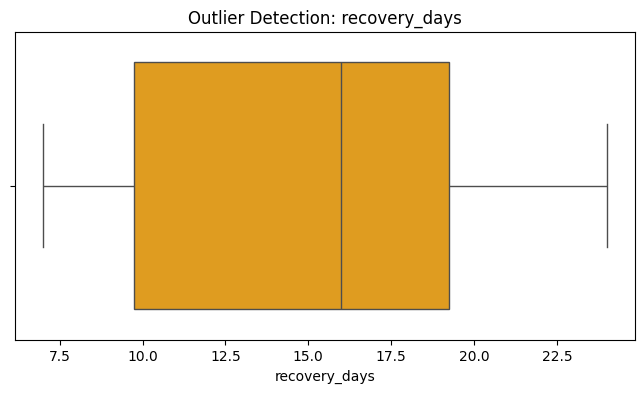

--- Outlier Detection for contact_number ---
Detected 4 outliers outside range (-97.75 - 170.25)



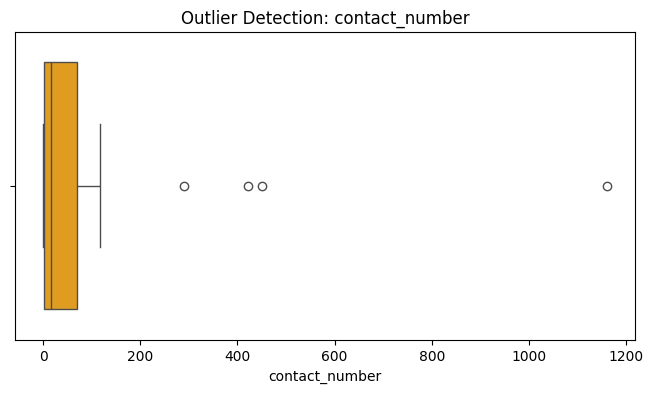

In [12]:

def detect_and_plot_outliers(data, column):
    if column not in data.columns or data[column].isnull().all():
        return data

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"--- Outlier Detection for {column} ---")
    print(f"Detected {len(outliers)} outliers outside range ({lower_bound:.2f} - {upper_bound:.2f})\n")

    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='orange')
    plt.title(f'Outlier Detection: {column}')
    plt.show()


    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


df_recovered = detect_and_plot_outliers(df_recovered, 'recovery_days')
df = detect_and_plot_outliers(df, 'contact_number')


/tmp/ipython-input-2602048405.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sex', palette='viridis')


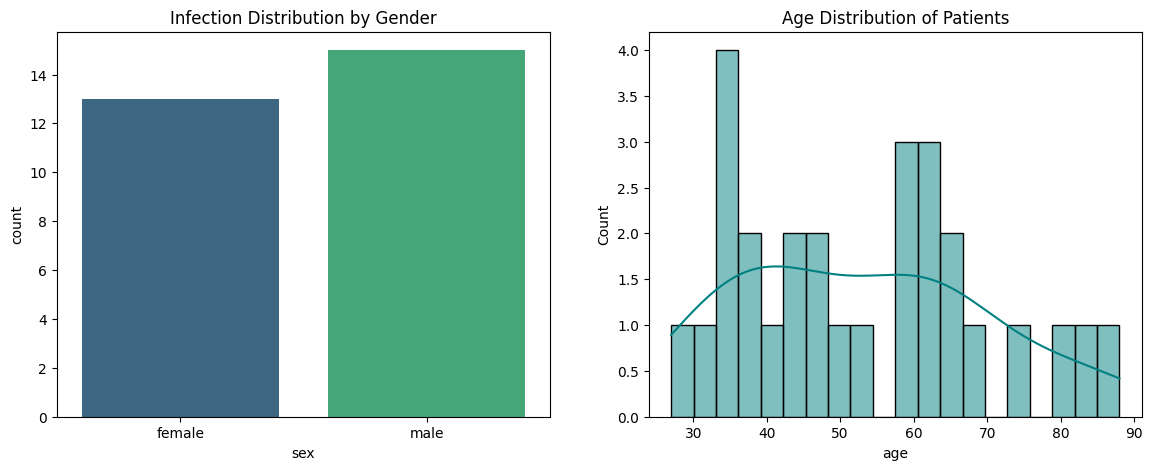

In [13]:

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sex', palette='viridis')
plt.title('Infection Distribution by Gender')

plt.subplot(1, 2, 2)
sns.histplot(df['age'].dropna(), bins=20, kde=True, color='teal')
plt.title('Age Distribution of Patients')
plt.show()

/tmp/ipython-input-2388115871.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reason_counts.values, y=reason_counts.index, palette='magma')


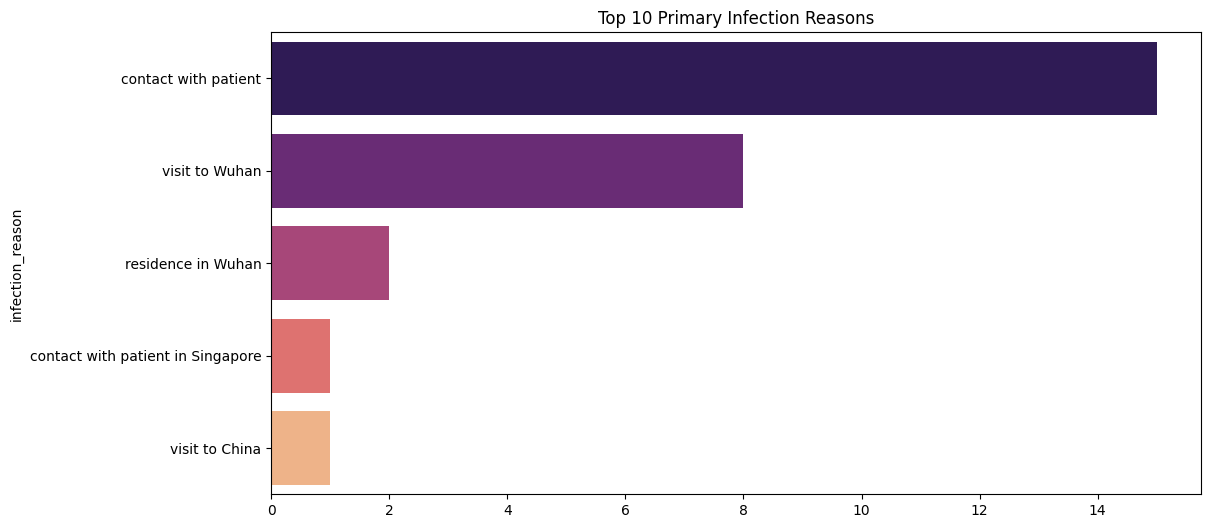

In [14]:

plt.figure(figsize=(12, 6))
reason_counts = df['infection_reason'].value_counts().head(10)
sns.barplot(x=reason_counts.values, y=reason_counts.index, palette='magma')
plt.title('Top 10 Primary Infection Reasons')
plt.show()


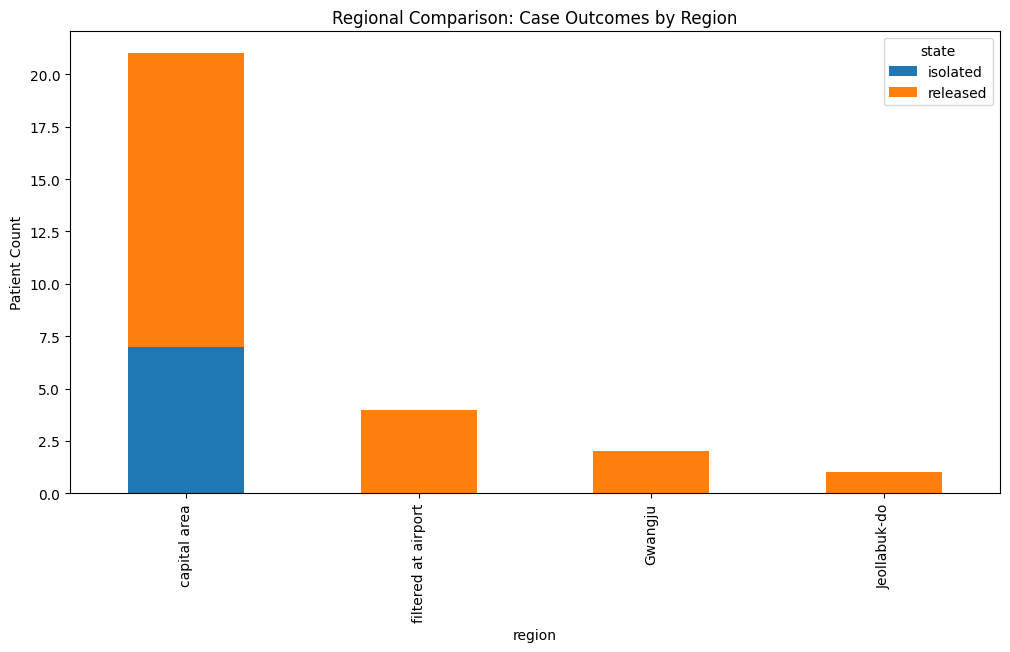

In [15]:

regional_summary = df.groupby(['region', 'state']).size().unstack().fillna(0)
if 'released' in regional_summary.columns:
    regional_summary.sort_values(by='released', ascending=False).head(10).plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Regional Comparison: Case Outcomes by Region')
    plt.ylabel('Patient Count')
    plt.show()


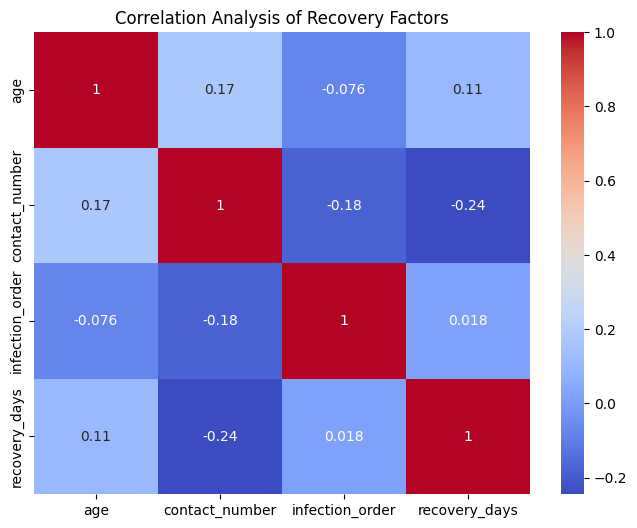

--- Linear Regression Performance ---
R-squared Score: -0.6577
Mean Squared Error: 11.54


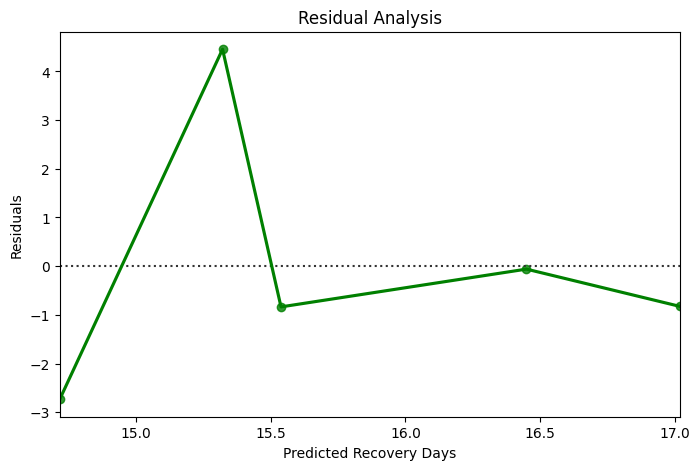

In [16]:

features = ['age', 'contact_number', 'infection_order']
target = 'recovery_days'


model_data = df_recovered[features + [target]].dropna()

if not model_data.empty:

    plt.figure(figsize=(8, 6))
    sns.heatmap(model_data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Analysis of Recovery Factors')
    plt.show()


    X = model_data[features]
    y = model_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    print("--- Linear Regression Performance ---")
    print(f"R-squared Score: {r2_score(y_test, y_pred):.4f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")

    plt.figure(figsize=(8, 5))
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, color="g")
    plt.title('Residual Analysis')
    plt.xlabel('Predicted Recovery Days')
    plt.ylabel('Residuals')
    plt.show()
else:
    print("Insufficient data for Linear Regression after handling missing values.")